In [1]:
import os
import janitor
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from stargazer.stargazer import Stargazer
from utils.utils import save_mpl_fig

FIGSAVEDIR = "../figs"    
DATAPATH = "../adult-data/output"        

## Prep data

In [2]:
# Read in list of classified FP (false positives)
falsepositives = (pd
                  .read_csv("../data/false_positives_list.csv")
                  ["flagged as FP"].tolist()
                 )
falsepositives

['9gag.com',
 'sniffies.com',
 'f95zone.to',
 'silverdaddies.com',
 'ttcache.com',
 'xlviirdr.com',
 '4chan.org',
 'thechive.com',
 'victoriassecret.com',
 'usasexguide.nl',
 'xlviiirdr.com',
 'xxxjmp.com',
 'urbandictionary.com',
 'lpsg.com']

In [3]:
# (fold cell) Load individual metadata
df_ind = (pd.read_csv("../data/individual_browsing_data.csv")
         )
df_ind.head(3)

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.00000,0.0,0.0,77642.0,77642.0,0.00000,0.0,1,1960,60,3600,4
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.73519,NaN,25952.0,234196.0,260148.0,9.97586,1.0,5,1990,31,961,4
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.00000,1.0,0.0,1182.0,1182.0,0.00000,0.0,1,1960,64,4096,4


In [4]:
# (fold cell) Load and prep web browsing data
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration", "visit_time_local"]
usecols = ["caseid", "category", "private_domain", "page_duration", "session_start_time"]

df = (pd.concat([
        # Get web_mobile
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_mobile_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ), 
        # Get web_desktop
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_desktop_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_2022-06-01_2022-06-30.csv"),
            usecols=usecols,
            low_memory=False,
        )
         # Renaming columns to be consistent w/ web_mobile & web_desktop
         .rename_column("page_duration", "visit_duration")
         .rename_column("session_start_time", "visit_time_local")
        )
        ])
      .query("category.str.contains('adult', case=False, na=False)")
      .query("private_domain not in @falsepositives")
      .dropna(subset=["caseid", "category", "visit_duration"])
      # Parse datetime string
      .assign(
          dt=lambda df: pd.to_datetime(df.visit_time_local),
          hour=lambda df: [datetime.hour for datetime in df["dt"]],
          hourdecimal=lambda df: [(datetime.hour + datetime.minute/60 + datetime.second/3600) for datetime in df["dt"]],
          dow=lambda df: [datetime.day_of_week for datetime in df["dt"]],
          dow_str=lambda df: [datetime.day_name() for datetime in df["dt"]],
          visit_minutes=lambda df: df["visit_duration"]/60
      )
      # ======================================================================
      .assign(time_8am_12pm=lambda  df: np.where((df["hour"] >=8)  & (df["hour"]<12), 1, 0))
      .assign(time_12pm_4pm=lambda  df: np.where((df["hour"] >=12)  & (df["hour"]<16), 1, 0))
      .assign(time_4pm_8pm=lambda  df: np.where((df["hour"] >=16)  & (df["hour"]<20), 1, 0))
      .assign(time_8pm_12am=lambda  df: np.where((df["hour"] >=20), 1, 0))
      .assign(time_12am_4am=lambda  df: np.where(df["hour"]<4, 1, 0))
      .assign(time_4am_8am=lambda  df: np.where((df["hour"] >=4)  & (df["hour"]<8), 1, 0))
      # ======================================================================
      .assign(time_7am_9am=lambda  df: np.where((df["hour"] >=7)  & (df["hour"]<9), 1, 0))
      .assign(time_9am_11am=lambda df: np.where((df["hour"] >=9)  & (df["hour"]<11), 1, 0))
      .assign(time_11am_1pm=lambda df: np.where((df["hour"] >=11) & (df["hour"]<13), 1, 0))
      .assign(time_1pm_3pm=lambda  df: np.where((df["hour"] >=13) & (df["hour"]<15), 1, 0))
      .assign(time_3pm_5pm=lambda  df: np.where((df["hour"] >=15) & (df["hour"]<17), 1, 0))
      .assign(time_5pm_7pm=lambda  df: np.where((df["hour"] >=17) & (df["hour"]<19), 1, 0))
      .assign(time_7pm_9pm=lambda  df: np.where((df["hour"] >=19) & (df["hour"]<21), 1, 0))
      .assign(time_9pm_11pm=lambda df: np.where((df["hour"] >=21) & (df["hour"]<23), 1, 0))
      .assign(time_11pm_1am=lambda df: np.where((df["hour"] >=23) | (df["hour"]<1), 1, 0))
      .assign(time_1am_3am=lambda  df: np.where((df["hour"] >=1)  & (df["hour"]<3), 1, 0))
      .assign(time_3am_5am=lambda  df: np.where((df["hour"] >=3)  & (df["hour"]<5), 1, 0))
      .assign(time_5am_7am=lambda  df: np.where((df["hour"] >=5)  & (df["hour"]<7), 1, 0))
      # ======================================================================
      # ======================================================================
      .assign(time_4am_5am=lambda  df: np.where((df["hour"] >=4)  & (df["hour"]<5), 1, 0))
      .assign(time_5am_6am=lambda  df: np.where((df["hour"] >=5)  & (df["hour"]<6), 1, 0))
      .assign(time_6am_7am=lambda  df: np.where((df["hour"] >=6)  & (df["hour"]<7), 1, 0))
      .assign(time_7am_8am=lambda  df: np.where((df["hour"] >=7)  & (df["hour"]<8), 1, 0))
      # ======================================================================
      # Get individual char
      .merge(df_ind, how="left", on="caseid", validate="m:1")
      .assign(R=lambda df: np.where(df["party"]=="R", 1, 0))
      .query("party!='I'")
     )
four_hour_bins = [
 'time_4am_8am',
 'time_8am_12pm',
 'time_12pm_4pm',
 'time_4pm_8pm',
 'time_8pm_12am',
 'time_12am_4am',
]
two_hour_bins = [
 'time_5am_7am',
 'time_7am_9am',
 'time_9am_11am',
 'time_11am_1pm',
 'time_1pm_3pm',
 'time_3pm_5pm',
 'time_5pm_7pm',
 'time_7pm_9pm',
 'time_9pm_11pm',
 'time_11pm_1am',
 'time_1am_3am',
 'time_3am_5am',
]
assert (df[four_hour_bins].sum(axis=1) == 1).all()
assert (df[two_hour_bins].sum(axis=1) == 1).all()
print("output = df with visits to adult sites")
print(f"{len(df)=:,}")
df.head()

output = df with visits to adult sites
len(df)=59,324


,caseid,private_domain,category,visit_time_local,visit_duration,dt,hour,hourdecimal,dow,dow_str,visit_minutes,time_8am_12pm,time_12pm_4pm,time_4pm_8pm,time_8pm_12am,time_12am_4am,time_4am_8am,time_7am_9am,time_9am_11am,time_11am_1pm,time_1pm_3pm,time_3pm_5pm,time_5pm_7pm,time_7pm_9pm,time_9pm_11pm,time_11pm_1am,time_1am_3am,time_3am_5am,time_5am_7am,time_4am_5am,time_5am_6am,time_6am_7am,time_7am_8am,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,R
0,201302005,adameve.com,"Adult, Shopping",2022-06-10 16:10:43,482,2022-06-10 16:10:43,16,16.178611,4,Friday,8.033333,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3,0
1,201302005,adameve.com,"Adult, Shopping",2022-06-12 15:47:02,2601,2022-06-12 15:47:02,15,15.783889,6,Sunday,43.350000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3,0
2,219344965,xhamster.com,Adult,2022-06-05 14:36:11,258,2022-06-05 14:36:11,14,14.603056,6,Sunday,4.300000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1996,2,1,3,1,1,6,40,3,D,3.0,230.0,233.0,1.287554,0.0,516.0,13602.0,14118.0,3.654909,1.0,1,2000,27,729,3,0
6,288967217,gosexpod.com,Adult,2022-06-18 13:41:02,458,2022-06-18 13:41:02,13,13.683889,5,Saturday,7.633333,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1982,2,3,3,1,1,6,22,3,D,9.0,130.0,139.0,6.474820,0.0,916.0,3558.0,4474.0,20.473849,1.0,3,1980,41,1681,3,0
7,214518153,pornhub.com,Adult,2022-06-15 16:57:39,272,2022-06-15 16:57:39,16,16.960833,2,Wednesday,4.533333,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1972,2,1,3,1,2,6,26,2,D,10.0,100.0,110.0,9.090909,0.0,1986.0,2815.0,4801.0,41.366382,1.0,1,1970,51,2601,3,0


In [5]:
z = "age + age2 + C(gender) + C(race2) + C(educ2) + C(region) + C(dow_str)"

## 4-hour bins

### OLS

In [6]:
x = "rep"
pvals = []
for timing in four_hour_bins:
    print(timing)
    y = timing
    print("Unadjusted")
    unadj_model = smf.ols(f"{y} ~ {x} + {z}", df)
    results_ = unadj_model.fit(cov_type="HC3")
    unadj_dict = dict(
            intercept=results_.params["Intercept"],
            estimate=results_.params[x],
            ll=results_.conf_int().loc[x][0],  # CI ll
            hl=results_.conf_int().loc[x][1],  # CI hl
            tstat=results_.tvalues[x],
            pval=results_.pvalues[x],
            obs=results_.nobs,
        )
    print(unadj_dict)

    print("Adjusted")
    adj_model = smf.ols(f"{y} ~ {x} + {z}", df)
    results_ = adj_model.fit(cov_type="HC3")
    adj_dict = dict(
            intercept=results_.params["Intercept"],
            estimate=results_.params[x],
            ll=results_.conf_int().loc[x][0],  # CI ll
            hl=results_.conf_int().loc[x][1],  # CI hl
            tstat=results_.tvalues[x],
            pval=results_.pvalues[x],
            obs=results_.nobs,
        )
    print(adj_dict)
    print("============================================")

time_4am_8am
Unadjusted
{'intercept': 0.29465135784205343, 'estimate': 0.09103590342403217, 'll': 0.08300710943562592, 'hl': 0.09906469741243842, 'tstat': 22.223398964878445, 'pval': 2.040291376568596e-109, 'obs': 54540.0}
Adjusted
{'intercept': 0.29465135784205343, 'estimate': 0.09103590342403217, 'll': 0.08300710943562592, 'hl': 0.09906469741243842, 'tstat': 22.223398964878445, 'pval': 2.040291376568596e-109, 'obs': 54540.0}
time_8am_12pm
Unadjusted
{'intercept': -0.1403976162226217, 'estimate': -0.06780687588446883, 'll': -0.07623489478414087, 'hl': -0.05937885698479679, 'tstat': -15.768715782413343, 'pval': 5.107781466136568e-56, 'obs': 54540.0}
Adjusted
{'intercept': -0.1403976162226217, 'estimate': -0.06780687588446883, 'll': -0.07623489478414087, 'hl': -0.05937885698479679, 'tstat': -15.768715782413343, 'pval': 5.107781466136568e-56, 'obs': 54540.0}
time_12pm_4pm
Unadjusted
{'intercept': 0.010755541458815961, 'estimate': -0.0037214936231999424, 'll': -0.013339582069721363, 'hl':

### WLS

In [7]:
def esttab_wls(outcomes, x, weights, df, z=None, significant_digits=2):

    ## Fit and store estimates
    unadj_results = []
    results = []
    pvals = []
    
    # Store WLS estimates
    for outcome in outcomes:
        ## Set up regression models
        if z is None:
            wls_model = smf.wls(f"{outcome} ~ {x}", weights=weights, data=df)
        else:
            wls_model = smf.wls(f"{outcome} ~ {x} + {z}", weights=weights, data=df)
        ## Estimate & store
        results_ = wls_model.fit(cov_type="HC3")
        results.append(results_)
        pvals.append(results_.pvalues[x])
#     print(results_.summary())

    ## Pvalue correction
    reject, p_corrected, _, alphacBonf = multipletests(pvals, alpha=.01, method='bonferroni')
    print(p_corrected)
    print(f"{alphacBonf=}")
    print("Rejected hypotheses:", reject)

    ## Report tables
    stargazer = Stargazer(results)
#     stargazer.significance_levels([alphacBonf]*3)
    stargazer.significance_levels([.05,.01,alphacBonf])

    ## Edit stargazer table (absent variables seem to be ignored)
    coeflabels = {
        "rep": "Republican", 
        "C(gender)[T.2]": "Female",
        "C(educ2)[T.2]": "Educ (HS)",
        "C(educ2)[T.3]": "Educ (some coll.)",
        "C(educ2)[T.4]": "Educ (coll. grad.)",
        "age": "Age",
        "age2": "Age$^2$",        
        "C(race2)[T.2]": "Race (Black)",
        "C(race2)[T.3]": "Race (Hispanic)",
        "C(race2)[T.4]": "Race (Asian)",
        "C(race2)[T.5]": "Race (Other)",
        "C(region)[T.2]": "Region (MW)",
        "C(region)[T.3]": "Region (South)",
        "C(region)[T.4]": "Region (West)",
        "Intercept": "Constant", 
    }
    stargazer.rename_covariates(coeflabels)
    if z is None:
        stargazer.covariate_order(["rep", "Intercept"])
    else:
        stargazer.covariate_order(coeflabels.keys())
    stargazer.significant_digits(significant_digits)

    ## Pare down to get LaTeX *fragment*
    latex_str = stargazer.render_latex()
    latex_fragment_str = "\n".join(latex_str.split("\n")[6:-11])
    # Remove the last \\ in the tex fragment to prevent the annoying
    # "Misplaced \noalign" LaTeX error when I use \bottomrule
    latex_fragment_str = latex_fragment_str[:-2]  
    
    ## Make sig stars compatible with downstream dcolumns in LaTeX
    latex_fragment_str = latex_fragment_str.replace("$^{}$", "")
    latex_fragment_str = latex_fragment_str.replace("$^{*}$", r"\sym{*}")
    latex_fragment_str = latex_fragment_str.replace("$^{**}$", r"\sym{**}")
    latex_fragment_str = latex_fragment_str.replace("$^{***}$", r"\sym{\dagger}")
    return latex_fragment_str, stargazer

In [8]:
latex_fragment_str, stargazer = esttab_wls(four_hour_bins, "rep", df["visit_minutes"], df, significant_digits=3)
with open(f"../tabs/regtab_wls_visit_timing_4hrbins.tex", "w") as tf:
    tf.write(latex_fragment_str)

stargazer

[1.         0.39151196 0.00272159 1.         1.         0.007024  ]
alphacBonf=0.0016666666666666668
Rejected hypotheses: [False False  True False False  True]


In [9]:
latex_fragment_str, stargazer = esttab_wls(four_hour_bins, "rep", df["visit_minutes"], z=z, df=df, significant_digits=3)
with open(f"../tabs/regtab_wls_visit_timing_4hrbins_adjusted.tex", "w") as tf:
    tf.write(latex_fragment_str)
    
stargazer

[7.31166719e-04 1.00000000e+00 4.96007088e-01 1.94012704e-02
 1.00000000e+00 1.00000000e+00]
alphacBonf=0.0016666666666666668
Rejected hypotheses: [ True False False False False False]


## Plot

In [10]:
unadj_results = []
for outcome in four_hour_bins:
    wls_model = smf.wls(f"{outcome} ~ {x}", weights=df["visit_minutes"], data=df)
    ## Estimate & store
    results_ = wls_model.fit(cov_type="HC3")
    dict_ = dict(
            estimate=results_.params[x],
            ll=results_.conf_int().loc[x][0],  # CI ll
            hl=results_.conf_int().loc[x][1],  # CI hl
            pval=results_.pvalues[x],
        )
    unadj_results.append(dict_)
    
df_unadj_plot = (
    pd.DataFrame(unadj_results)
    .assign(time=four_hour_bins)
    .assign(ix=range(1,7))
    .assign(ix=lambda df_: df_["ix"]-.05)
)
df_unadj_plot    

,estimate,ll,hl,pval,time,ix
0,-0.003920,-0.038208,0.030368,0.822700,time_4am_8am,0.95
1,0.028035,-0.001771,0.057840,0.065252,time_8am_12pm,1.95
2,0.041992,0.018522,0.065462,0.000454,time_12pm_4pm,2.95
3,0.004260,-0.015018,0.023538,0.664916,time_4pm_8pm,3.95
4,-0.012126,-0.037742,0.013489,0.353497,time_8pm_12am,4.95
5,-0.058241,-0.093409,-0.023074,0.001171,time_12am_4am,5.95


In [11]:
adj_results = []
for outcome in four_hour_bins:
    wls_model = smf.wls(f"{outcome} ~ {x} + {z}", weights=df["visit_minutes"], data=df)
    ## Estimate & store
    results_ = wls_model.fit(cov_type="HC3")
    dict_ = dict(
            estimate=results_.params[x],
            ll=results_.conf_int().loc[x][0],  # CI ll
            hl=results_.conf_int().loc[x][1],  # CI hl
            pval=results_.pvalues[x],
        )
    adj_results.append(dict_)
    

df_adj_plot = (
    pd.DataFrame(adj_results)
    .assign(time=four_hour_bins)
    .assign(ix=range(1,7))
    .assign(ix=lambda df_: df_["ix"]+.05)
)
df_adj_plot

,estimate,ll,hl,pval,time,ix
0,0.047034,0.023042,0.071026,0.000122,time_4am_8am,1.05
1,-0.012197,-0.037841,0.013447,0.351212,time_8am_12pm,2.05
2,0.035030,-0.004533,0.074592,0.082668,time_12pm_4pm,3.05
3,-0.039577,-0.065920,-0.013234,0.003234,time_4pm_8pm,4.05
4,-0.007390,-0.041840,0.027060,0.674171,time_8pm_12am,5.05
5,-0.022900,-0.058141,0.012342,0.202812,time_12am_4am,6.05


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.3, style='white')

In [13]:
import matplotlib.lines as mlines


In [14]:
df_adj_plot.loc[0, "estimate"]

0.047034284454459764

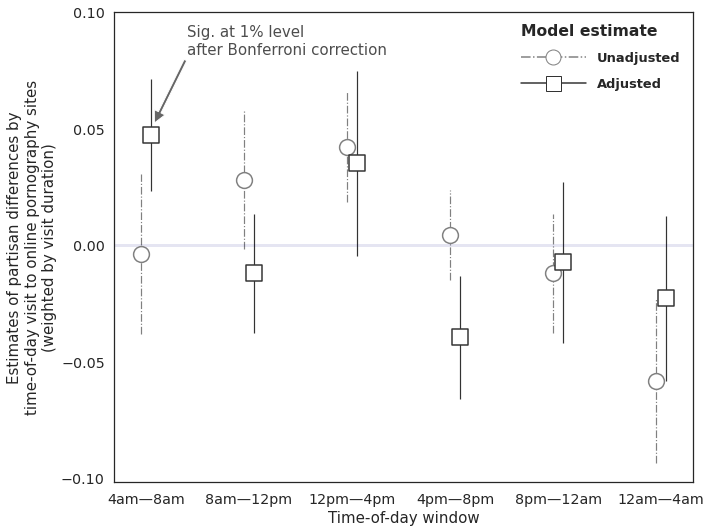

In [15]:
_scale=2.5
_, ax = plt.subplots(figsize=(4*_scale,3*_scale))

SCATTER_OPTS = dict(y="estimate", x="ix", s=250, linewidth=1.5, color="1")
CI_OPTS = dict(y="estimate", x="ix", ls="none", linewidth=1.2, zorder=0)
ADJ_COLOR = ".2"
UNADJ_COLOR = ".5"
UNADJ_MSYMBOL = "o"
ADJ_MSYMBOL = "s"
UNADJ_LS = "-."

ax.scatter(
    data=df_unadj_plot, 
    marker=UNADJ_MSYMBOL,
    edgecolors=UNADJ_COLOR,
    **SCATTER_OPTS,
)

eb = ax.errorbar(
    data=df_unadj_plot,
    yerr=[df_unadj_plot["estimate"] - df_unadj_plot["ll"], df_unadj_plot["hl"] - df_unadj_plot["estimate"]],
    color=UNADJ_COLOR,
    **CI_OPTS,
)
eb[-1][0].set_linestyle(UNADJ_LS)
    
ax.scatter(
    data=df_adj_plot,
    marker=ADJ_MSYMBOL,
    edgecolors=ADJ_COLOR,
    **SCATTER_OPTS,
)

ax.errorbar(
    data=df_adj_plot,
    yerr=[df_adj_plot["estimate"] - df_adj_plot["ll"], df_adj_plot["hl"] - df_adj_plot["estimate"]],
    color=ADJ_COLOR,
    **CI_OPTS,
)

MLINE_OPTS = dict( markerfacecolor="1", markersize=15,)
unadj_hand = mlines.Line2D([], [], 
                         color=UNADJ_COLOR,markeredgecolor=UNADJ_COLOR, marker=UNADJ_MSYMBOL, ls=UNADJ_LS,
                          label='Unadjusted', **MLINE_OPTS
                        )
adj_hand = mlines.Line2D([], [], 
                         color=ADJ_COLOR, marker=ADJ_MSYMBOL, ls="-",
                         label='Adjusted', **MLINE_OPTS
                        )
custom_legend = plt.legend(
    handles=[unadj_hand, adj_hand], 
    handlelength=5, 
    handletextpad=.9,
    labelspacing=1,
    title="Model estimate", 
    frameon=False,
    loc="best",
    prop={'weight':'bold', "size":13},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

ax.annotate(
    "Sig. at 1% level\nafter Bonferroni correction", 
    color=".3",
    fontsize=15,
    xy=(1.08, df_adj_plot.loc[0, "estimate"]+.005), 
    xytext=(1.4, .082), 
    arrowprops=dict(facecolor='.4', shrink=0.01, width=3,)
)
plt.axhline(y=0, color='navy', alpha=.1, linewidth=3, linestyle='-', zorder=0)
ax.set_yticks([-.1, -.05, 0, .05, .1])
ax.set_xticks(range(1, 7))
ax.set_xlabel("Time-of-day window", fontsize=15)
ax.set_ylabel("Estimates of partisan differences by\ntime-of-day visit to online pornography sites\n(weighted by visit duration)", fontsize=15)
ax.set_xticklabels(["4am\u20148am", "8am\u201412pm", "12pm\u20144pm" ,"4pm\u20148pm", "8pm\u201412am", "12am\u20144am"]) # 0.5 is half of the "1" auto width
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "time-of-day-wls-estimates"))

## 2 hour bins

In [16]:
latex_fragment_str, stargazer = esttab_wls(two_hour_bins, "rep", df["visit_minutes"], df, significant_digits=3)
# with open(f"../tabs/regtab_wls_visit_timing_4hrbins.tex", "w") as tf:
#     tf.write(latex_fragment_str)

stargazer

[1.00000000e+00 1.00000000e+00 7.69237137e-02 4.70796386e-08
 4.35068243e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.92914709e-01 5.71226524e-06 1.00000000e+00]
alphacBonf=0.0008333333333333334
Rejected hypotheses: [False False False  True False False False False False False  True False]


In [17]:
two_hour_bins

['time_5am_7am',
 'time_7am_9am',
 'time_9am_11am',
 'time_11am_1pm',
 'time_1pm_3pm',
 'time_3pm_5pm',
 'time_5pm_7pm',
 'time_7pm_9pm',
 'time_9pm_11pm',
 'time_11pm_1am',
 'time_1am_3am',
 'time_3am_5am']

In [18]:
latex_fragment_str, stargazer = esttab_wls(two_hour_bins, "rep", df["visit_minutes"], z=z, df=df, significant_digits=3)
# with open(f"../tabs/regtab_wls_visit_timing_4hrbins_adjusted.tex", "w") as tf:
#     tf.write(latex_fragment_str)
    
stargazer

[1.08681128e-06 1.00000000e+00 8.12175974e-05 7.20869629e-01
 7.07761990e-01 1.00000000e+00 3.71492067e-02 2.95774498e-01
 1.00000000e+00 1.00000000e+00 7.28393980e-01 9.43336949e-01]
alphacBonf=0.0008333333333333334
Rejected hypotheses: [ True False  True False False False False False False False False False]


## By hours

In [ ]:
time_4am_to_8am = [
 'time_4am_5am',
 'time_5am_6am',
 'time_6am_7am',
 'time_7am_8am',
]

In [ ]:
latex_fragment_str, stargazer = esttab_wls(time_4am_to_8am, "rep", df["visit_minutes"], z=z, df=df, significant_digits=3)

stargazer